In [1]:
import tensorflow as tf
import os

import cv2 
from PIL import Image
import imghdr
import numpy as np
from matplotlib import pyplot as plt


C:\Users\thovu\AppData\Local\Temp\ipykernel_30060\429596481.py:6: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
#Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [48]:
data_dir = 'data'
image_exts = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)

            if tip not in image_exts:
                print("Image ext not in list {}".format(image_path))
                print("tip: {}".format(tip))
                os.remove(image_path)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

In [5]:
# img = cv2.imread(os.path.join('data','blue_dreams','48b0ca_c3c6ed33d29d4d3db6229f8edb345e5emv2.jpg'))

#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.imshow(cv2.cvtColor(img,cv2.COLOR_BAYER_BG2RGB))

In [49]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)


Found 1505 files belonging to 2 classes.


In [6]:

data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 1535 files belonging to 2 classes.


In [ ]:
# Class 0 = Blue Dreams
#Class 1 = Cherry Shrimp

batch[1]

In [50]:
data = data.map(lambda x,y: (x/255, y))

In [34]:

scaled_iterator =data.as_numpy_iterator()



In [41]:
batch = scaled_iterator.next()

In [47]:
batch[0].max()

255.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..209.94891].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


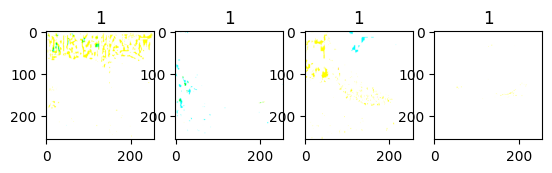

In [51]:
fig, ax = plt.subplots(ncols=4)
# fig.set_size_inches(20,20)
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].set_title(batch[1][idx])

In [38]:
train_size = int(len(data)*.7)
validation_size = int(len(data)*.2)
test_size = int(len(data)*.1)


train = data.take(train_size)
validation = data.skip(train_size).take(validation_size)
test = data.skip(train_size+validation_size).take(test_size)


33

In [15]:
# from tensorflow.keras.models import Functional This is probably what I want to use for multiple input and output types
from tensorflow.keras.models import Sequential # 1 data in 1 data out, flows top to bottom
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
import tensorflow as tf

In [16]:

# import tensorflow as tf
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), strides=1, activation='relu', input_shape=(416, 416, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), strides=1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), strides=1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))



C:\Users\thovu\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

In [18]:
log_dir = 'logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)



In [19]:
history = model.fit(train, epochs=20, validation_data=validation, callbacks=[tensorboard_callback])

Epoch 1/20


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 80000, but received input with shape (None, 28800)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 256, 256, 3), dtype=float32)
  • training=True
  • mask=None

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_acc')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()